In [1]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
# Read Data from CSV - point | x_coord | y_coord | Demand
data = pd.read_csv('data.csv')

#---------------Aquí---------------------
#data = data[data['CADENA']!='Nutrisa']

# Extract Depot and Clients Information
depot = (data.loc[data['DET'] == 1, 'LONGITUD'].values[0], data.loc[data['DET'] == 1, 'LATITUD'].values[0])

clients = {
    row['DET']: (row['LONGITUD'], row['LATITUD'])
    for idx, row in data.iterrows() if row['DET'] != 1
}

demands = {
    row['DET']: row['DEMAND']
    for idx, row in data.iterrows() if row['DET'] != 1
}

vehicle_capacity = 6


In [3]:
# Calculate Angles from depot
def calculate_angle(client, depot):
  return math.atan2(client[1] - depot[1], client[0] - depot[0])

angles = {client: calculate_angle(coord, depot) for client, coord in clients.items()}

sorted_clients = sorted(clients.keys(), key = lambda client: angles[client])

In [4]:
# Cluster Clients Based on Vehicle Capacity
clusters = []
current_cluster =[]
current_demand = 0

for client in sorted_clients:
  if current_demand + demands[client] > vehicle_capacity:
    clusters.append(current_cluster)
    current_cluster = []
    current_demand = 0
  current_cluster.append(client)
  current_demand += demands[client]

if current_cluster:
  clusters.append(current_cluster)

In [5]:
# Define the TSP Solver Function
def solve_tsp(cluster, distances):
  model = pyo.ConcreteModel()

  model.nodes = pyo.Set(initialize = cluster)
  model.x = pyo.Var(model.nodes, model.nodes, within = pyo.Binary)
  model.u = pyo.Var(model.nodes, within = pyo.NonNegativeIntegers)

  def obj_rule(model):
    return sum(model.x[i,j]*distances[i,j] for i in model.nodes for j in model.nodes if i!=j)
  model.obj = pyo.Objective(rule = obj_rule, sense = pyo.minimize)

  def visit_rule(model, i):
    return sum(model.x[i,j] for j in model.nodes if j != i) == 1
  model.visit = pyo.Constraint(model.nodes, rule = visit_rule)

  def leave_rule(model, j):
    return sum(model.x[i,j] for i in model.nodes if i != j) == 1
  model.leave = pyo.Constraint(model.nodes, rule = leave_rule)

  def subtour_elimination_rule(model, i, j):
    if i!=j and (i != 0 and j != 0):
      return model.u[i] - model.u[j] + len(cluster) * model.x[i,j] <= len(cluster) - 1
    return pyo.Constraint.Skip
  model.subtour_elimination = pyo.Constraint(model.nodes, model.nodes, rule = subtour_elimination_rule)

  solver = SolverFactory('cplex_direct')
  solver.solve(model)

  solution = [(i, j) for i in cluster for j in cluster if i != j  and pyo.value(model.x[i,j]) > 0.5]
  return solution

In [6]:
# Calculate Distances
def manhattan_distance(p1, p2):
  return (abs(p1[0] - p2[0]) + abs(p1[1] - p2[1]))

distances = {(i, j): manhattan_distance(clients[i], clients[j]) for i in clients for j in clients if i!=j}
for i in clients:
  distances[(0,i)] = manhattan_distance(depot, clients[i])
  distances[(i,0)] = manhattan_distance(clients[i], depot)

In [7]:
# Solve TSP for Each Cluster
routes = []
for cluster in clusters:
  cluster = [0] + cluster
  route = solve_tsp(cluster, distances)
  routes.append(route)

In [8]:
print(clusters)

[[12268, 12078, 3816, 3825, 12809, 12057], [376, 305, 3504, 5765, 5855, 109], [3480, 3629, 435, 3034, 231, 12023], [14, 3829, 402, 3812, 3826, 377], [805, 12070, 3830, 137, 3849, 3881], [12518, 3858, 3841, 98, 379, 12326], [652, 5817, 12389, 3850, 3877, 131], [3876, 3915, 3837, 3839, 3844, 12130], [12008, 12088, 2829, 3815, 12716, 3813], [2830, 380, 3818, 1083, 12794, 12046], [5462, 12002, 12589, 420, 3863, 2430], [12001, 13220, 12052, 17, 12811, 2644], [1118, 3397, 3177, 814, 12929, 287], [2766, 12723, 12996, 12033, 363, 3479], [12131, 13124, 431, 12016, 3827, 237], [3820, 12107, 3223, 12075, 3828, 229], [3819, 227, 1770, 1053, 12323, 12238], [423, 3843, 12803, 3857, 235, 12793], [55, 12031, 12032, 3831, 3835, 233], [3840, 2041, 2382, 3810, 3811, 12534], [12807, 3809, 3199, 234, 154, 12725], [2670, 13960, 12384, 12082, 252, 13632], [1492, 4191, 4547, 2347, 13206, 232], [230, 12003, 12343, 13603, 12561, 3799], [670, 2033, 149, 12810, 1513, 12061], [12381, 12590, 12596, 12795, 2079, 127

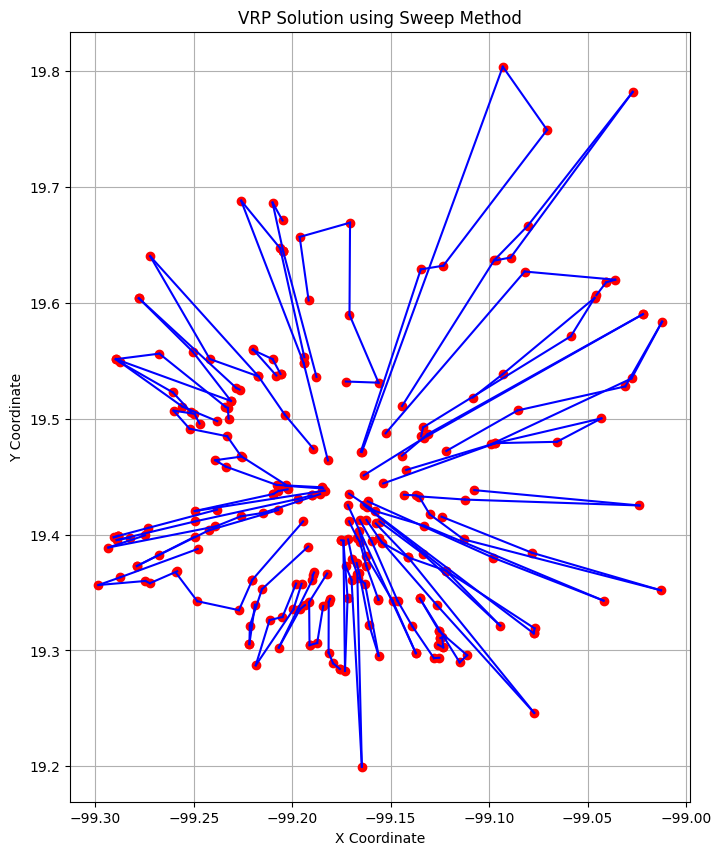

In [9]:
# Nuevo código para graficar solo clusters conectados sin el depot en las rutas y exportar las nuevas rutas

# Crear lista para almacenar las rutas finales sin el depot
rutas_final = []

# Plot Solution
plt.figure(figsize = (8,10))

# Plot clients
for client, coord in clients.items():
    plt.plot(coord[0], coord[1], 'ro')

# Plot routes
for route in routes:
    nueva_ruta = []  # Para almacenar la nueva ruta sin el depot
    for (i, j) in route:
        # Si i y j no son el depot (0), agregar el segmento a la nueva ruta
        if i != 0 and j != 0:
            start = clients[i]
            end = clients[j]
            plt.plot([start[0], end[0]], [start[1], end[1]], 'b-')
            nueva_ruta.append((i, j))  # Agregar el segmento a la nueva ruta
    rutas_final.append(nueva_ruta)  # Agregar la nueva ruta sin el depot a la lista rutas_final

for ruta in rutas_final:
    ruta.reverse()

plt.grid(True)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('VRP Solution using Sweep Method')
plt.savefig('ConNutrisa.jpeg')
plt.show()

In [10]:
rutas_cadena = []
for i in range(len(rutas_final)-1):
    rutas_cadena.append([])
    for j in range(5):
        rutas_cadena[i].append([])

for i in range(len(rutas_final)-1):
    for j in range(5):
        rutas_cadena[i][j] = [rutas_final[i][j][0],data['CADENA'][data[data['DET'] == rutas_final[i][j][0]].index[0]], rutas_final[i][j][1],data['CADENA'][data[data['DET'] == rutas_final[i][j][1]].index[0]]]

In [11]:
rutas_cadena

[[[12057, 'Nutrisa', 3825, 'Walmart Mexico'],
  [12809, 'Nutrisa', 12057, 'Nutrisa'],
  [3825, 'Walmart Mexico', 3816, 'Walmart Mexico'],
  [3816, 'Walmart Mexico', 12078, 'Nutrisa'],
  [12078, 'Nutrisa', 12268, 'Nutrisa']],
 [[109, 'Chedraui', 5765, 'Walmart Mexico'],
  [5855, 'Walmart Mexico', 3504, 'Walmart Mexico'],
  [3504, 'Walmart Mexico', 109, 'Chedraui'],
  [305, 'La Comer', 5855, 'Walmart Mexico'],
  [376, 'La Comer', 305, 'La Comer']],
 [[12023, 'Nutrisa', 3034, 'Walmart Mexico'],
  [231, 'Chedraui', 3629, 'Walmart Mexico'],
  [3034, 'Walmart Mexico', 435, 'La Comer'],
  [435, 'La Comer', 231, 'Chedraui'],
  [3629, 'Walmart Mexico', 3480, 'Walmart Mexico']],
 [[377, 'La Comer', 3829, 'Walmart Mexico'],
  [3826, 'Walmart Mexico', 3812, 'Walmart Mexico'],
  [3812, 'Walmart Mexico', 377, 'La Comer'],
  [402, 'La Comer', 3826, 'Walmart Mexico'],
  [14, 'La Comer', 402, 'La Comer']],
 [[3881, 'Walmart Mexico', 12070, 'Nutrisa'],
  [3849, 'Walmart Mexico', 3881, 'Walmart Mexico'],

In [12]:
import folium
# Diccionario para almacenar las coordenadas de cada cluster
coordenadas_clusters = []

for cluster in clusters:
    coordenadas = data[data['DET'].isin(cluster)][['LATITUD', 'LONGITUD']].values.tolist()
    coordenadas_clusters.append(coordenadas)

# Crea un mapa centrado en la Ciudad de México
mapa = folium.Map(location=[19.432608, -99.133209], zoom_start=14)

# Colores para los diferentes clusters
colores = ['blue', 'green', 'red', 'purple', 'orange']

# Agrega los puntos y las rutas para cada cluster
for idx, coordenadas in enumerate(coordenadas_clusters):
    color = colores[idx % len(colores)]  # Cicla a través de los colores disponibles
    
    # Agrega los puntos al mapa
    for lat, lon in coordenadas:
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,  # Tamaño del marcador
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(mapa)
    
    # Dibuja las rutas entre los puntos del cluster
    if len(coordenadas) > 1:  # Solo dibuja la línea si hay más de un punto en el cluster
        folium.PolyLine(locations=coordenadas, color=color, weight=2.5).add_to(mapa)

# Guarda el mapa en un archivo HTML
mapa.save("mapa_clusters_cdmx(conNutrisa).html")

In [13]:
from geopy.distance import geodesic

# Diccionario para almacenar las coordenadas de cada cluster
coordenadas_clusters = []

for cluster in clusters:
    coordenadas = data[data['DET'].isin(cluster)][['LATITUD', 'LONGITUD']].values.tolist()
    coordenadas_clusters.append(coordenadas)

# Función para calcular la distancia total de un cluster
def calcular_distancia_total(cluster_coordenadas):
    distancia_total = 0.0
    for i in range(len(cluster_coordenadas) - 1):
        punto1 = cluster_coordenadas[i]
        punto2 = cluster_coordenadas[i + 1]
        distancia_total += geodesic(punto1, punto2).kilometers
    return distancia_total

# Calcula la distancia total para cada cluster
distancias_clusters = [calcular_distancia_total(cluster) for cluster in coordenadas_clusters]

# Muestra la distancia total de cada cluster
for idx, distancia in enumerate(distancias_clusters):
    print(f"Distancia total del cluster {idx + 1}: {distancia:.2f} km")

Distancia total del cluster 1: 10.11 km
Distancia total del cluster 2: 11.95 km
Distancia total del cluster 3: 31.61 km
Distancia total del cluster 4: 24.62 km
Distancia total del cluster 5: 20.49 km
Distancia total del cluster 6: 12.89 km
Distancia total del cluster 7: 23.88 km
Distancia total del cluster 8: 13.85 km
Distancia total del cluster 9: 16.24 km
Distancia total del cluster 10: 18.22 km
Distancia total del cluster 11: 18.18 km
Distancia total del cluster 12: 25.81 km
Distancia total del cluster 13: 36.06 km
Distancia total del cluster 14: 43.85 km
Distancia total del cluster 15: 11.12 km
Distancia total del cluster 16: 20.88 km
Distancia total del cluster 17: 50.94 km
Distancia total del cluster 18: 41.00 km
Distancia total del cluster 19: 2.02 km
Distancia total del cluster 20: 12.50 km
Distancia total del cluster 21: 49.41 km
Distancia total del cluster 22: 31.26 km
Distancia total del cluster 23: 26.46 km
Distancia total del cluster 24: 19.14 km
Distancia total del cluste

In [14]:
from geopy.distance import geodesic

# Diccionario para almacenar las coordenadas de cada cluster
coordenadas_clusters = []

for cluster in clusters:
    coordenadas = data[data['DET'].isin(cluster)][['LATITUD', 'LONGITUD']].values.tolist()
    coordenadas_clusters.append(coordenadas)

# Función para calcular la distancia total de un cluster
def calcular_distancia_total(cluster_coordenadas):
    distancias = []
    for i in range(len(cluster_coordenadas) - 1):
        punto1 = cluster_coordenadas[i]
        punto2 = cluster_coordenadas[i + 1]
        distancias.append(geodesic(punto1, punto2).kilometers)
    return distancias

# Calcula la distancia total para cada cluster
distancias_clusters = [calcular_distancia_total(cluster) for cluster in coordenadas_clusters]

# Muestra la distancia total de cada cluster
for idx, distancia in enumerate(distancias_clusters):
    print("Distancia total del cluster ", idx + 1, ': ',  distancia)

Distancia total del cluster  1 :  [4.849839516393469, 0.5233837743135931, 1.9803177678189112, 2.7568125204589697, 0.0]
Distancia total del cluster  2 :  [2.0444685924603334, 4.061514646943999, 5.847062779569668, 0.0, 0.0]
Distancia total del cluster  3 :  [3.9723497368124017, 5.933123161008194, 9.696991679099932, 0.7654998322884495, 11.24049823970133, 0.0]
Distancia total del cluster  4 :  [8.896868470647128, 2.2755260634085084, 5.410504364270469, 1.6556312134506914, 6.377896652483642]
Distancia total del cluster  5 :  [3.5389213150856573, 2.5767509153435477, 5.133125713714642, 9.245544493397166, 0.0]
Distancia total del cluster  6 :  [0.3205049228908465, 1.8516394035974086, 4.399767728431117, 1.3764691532081403, 4.943253924149088]
Distancia total del cluster  7 :  [4.95133185095759, 9.145851403994847, 6.206954574536678, 0.0, 3.573161395108842]
Distancia total del cluster  8 :  [4.7594890158139025, 3.547842934315488, 1.761569970210506, 0.0, 3.784497232240537]
Distancia total del cluste